In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import networkx as nx
import time

import spotify_credentials

In [2]:
"""Get an OAuth token using the Client Credentials Flow."""
token_url = 'https://accounts.spotify.com/api/token'
headers = {'Content-Type': 'application/x-www-form-urlencoded'}
data = {'grant_type': 'client_credentials'}
response = requests.post(token_url, headers=headers, data=data, auth=(spotify_credentials.client_id, spotify_credentials.client_secret))
response.raise_for_status()
token = response.json()['access_token']

In [3]:
def search_artist(artist_name):
    """Search for an artist and return their Spotify ID."""
    search_url = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {token}'}
    params = {'q': artist_name, 'type': 'artist', 'limit': 1}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    results = response.json()['artists']['items']
    if results:
        return results[0]['id']
    return None

def get_artist(artist_id):
    """Get artist information."""
    url = f'https://api.spotify.com/v1/artists/{artist_id}'
    headers = {'Authorization': f'Bearer {token}'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

def get_artist_top_tracks(artist_id, market='US'):
    """Get the top tracks for an artist."""
    url = f'https://api.spotify.com/v1/artists/{artist_id}/top-tracks'
    headers = {'Authorization': f'Bearer {token}'}
    params = {'market': market}
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()['tracks']

def get_track_audio_features(track_id):
    """Get audio features for a track."""
    url = f'https://api.spotify.com/v1/audio-features/{track_id}'
    headers = {'Authorization': f'Bearer {token}'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

def get_artist_name(artist_id):
    """Get the name of an artist given their Spotify ID."""
    url = f'https://api.spotify.com/v1/artists/{artist_id}'
    headers = {'Authorization': f'Bearer {token}'}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()['name']

In [4]:
artist_name = 'Taylor Swift'
search_artist(artist_name)

'06HL4z0CvFAxyc27GXpf02'

## Module 2 - Graph Analysis
In this module, Ryan analyzed connections between different artists on Spotify. From this analysis, we will used supervised learning to predict whether a song will be a hit or not. 

https://medium.com/inst414-data-science-tech/a-groovy-network-analysis-how-features-on-rap-songs-benefit-everyone-50fda2bb91ee

In [5]:
# List of selected artists
artists = [
    "Westside Gunn", "Conway the Machine", "Freddie Gibbs", "Benny the Butcher", "Larry June", "Roc Marciano"]

g = nx.Graph()

if __name__ == '__main__':
    
    # Loop through each artist, get their Spotify ID and top tracks
    for artist in artists:
        artist_id = search_artist(artist)
        if artist_id is None:
            print(f"Could not find Spotify data for {artist}")
            continue
        
        print(f"\nArtist: {artist} (ID: {artist_id})")
        top_tracks = get_artist_top_tracks(artist_id)
        
        # For each track, add nodes for every artist and create edges between them
        for track in top_tracks:
            track_name = track['name']
            # Each track contains a list of artists (each a dict with 'id' and 'name')
            track_artists = track['artists']
            
            # Add every artist as a node (using their Spotify ID as the unique identifier)
            for a in track_artists:
                g.add_node(a['id'], name=a['name'])
            
            # Create an edge between every pair of artists on the track
            for i in range(len(track_artists)):
                for j in range(i + 1, len(track_artists)):
                    a_id = track_artists[i]['id']
                    b_id = track_artists[j]['id']
                    
                    # If an edge already exists, increment the weight; otherwise, add a new edge with weight 1.
                    if g.has_edge(a_id, b_id):
                        g[a_id][b_id]['weight'] += 1
                    else:
                        g.add_edge(a_id, b_id, weight=1)
                    
                    print(f"{track_artists[i]['name']} <-> {track_artists[j]['name']} on '{track_name}'")



Artist: Westside Gunn (ID: 0ABk515kENDyATUdpCKVfW)
Westside Gunn <-> Doechii on 'EGYPT - Remix'
Travis Scott <-> Westside Gunn on 'LOST FOREVER (feat. Westside Gunn)'
Westside Gunn <-> Joey Bada$$ on '327 (feat. Tyler, The Creator & Billie Essco)'
Westside Gunn <-> Tyler, The Creator on '327 (feat. Tyler, The Creator & Billie Essco)'
Westside Gunn <-> Billie Essco on '327 (feat. Tyler, The Creator & Billie Essco)'
Joey Bada$$ <-> Tyler, The Creator on '327 (feat. Tyler, The Creator & Billie Essco)'
Joey Bada$$ <-> Billie Essco on '327 (feat. Tyler, The Creator & Billie Essco)'
Tyler, The Creator <-> Billie Essco on '327 (feat. Tyler, The Creator & Billie Essco)'
Statik Selektah <-> Westside Gunn on 'The Louvre'
Statik Selektah <-> Joey Bada$$ on 'The Louvre'
Statik Selektah <-> Rome Streetz on 'The Louvre'
Statik Selektah <-> Stove God Cooks on 'The Louvre'
Westside Gunn <-> Joey Bada$$ on 'The Louvre'
Westside Gunn <-> Rome Streetz on 'The Louvre'
Westside Gunn <-> Stove God Cooks on

In [6]:
# Create a DataFrame of source artists, track artists, and track name from the graph

track_collab_data = []

for artist in artists:
    artist_id = search_artist(artist)
    if artist_id is None:
        continue
    top_tracks = get_artist_top_tracks(artist_id)

    for track in top_tracks:
        track_id = track['id']
        track_artists = track['artists']
        track_popularity = track['popularity']
        for a in track_artists:
            track_collab_data.append({
                "source_artist": artist_id,
                "track_artist": a['id'],
                "track_id": track_id,
                "track_popularity": track_popularity
            })
    
track_collab_df = pd.DataFrame(track_collab_data)
track_collab_df['source_artist'] = track_collab_df['source_artist'].astype("str")
track_collab_df['track_artist'] = track_collab_df['track_artist'].astype("str")
track_collab_df

,source_artist,track_artist,track_id,track_popularity
0,0ABk515kENDyATUdpCKVfW,0ABk515kENDyATUdpCKVfW,61b65LQ9rxhcMtDEusHPZL,68
1,0ABk515kENDyATUdpCKVfW,4E2rKHVDssGJm2SCDOMMJB,61b65LQ9rxhcMtDEusHPZL,68
2,0ABk515kENDyATUdpCKVfW,0Y5tJX1MQlPlqiwlOH1tJY,7EiUtdeoWcKqLi5ELZCjYf,66
3,0ABk515kENDyATUdpCKVfW,0ABk515kENDyATUdpCKVfW,7EiUtdeoWcKqLi5ELZCjYf,66
4,0ABk515kENDyATUdpCKVfW,0ABk515kENDyATUdpCKVfW,5sxRbu2Oi9lgmLO8taA3Rf,64
...,...,...,...,...
132,5X0V59ipZnbvnubW0rQVri,4Ci4iocESnJs9M0L5KpcGc,7D3P9mCe7VtoLnBRGO519h,39
133,5X0V59ipZnbvnubW0rQVri,5X0V59ipZnbvnubW0rQVri,7D3P9mCe7VtoLnBRGO519h,39
134,5X0V59ipZnbvnubW0rQVri,5X0V59ipZnbvnubW0rQVri,25hZPbLV8CnhEjFfiA0ZrD,40
135,5X0V59ipZnbvnubW0rQVri,4Ci4iocESnJs9M0L5KpcGc,3huMCqWZWh1aiSE0IK3hfG,38


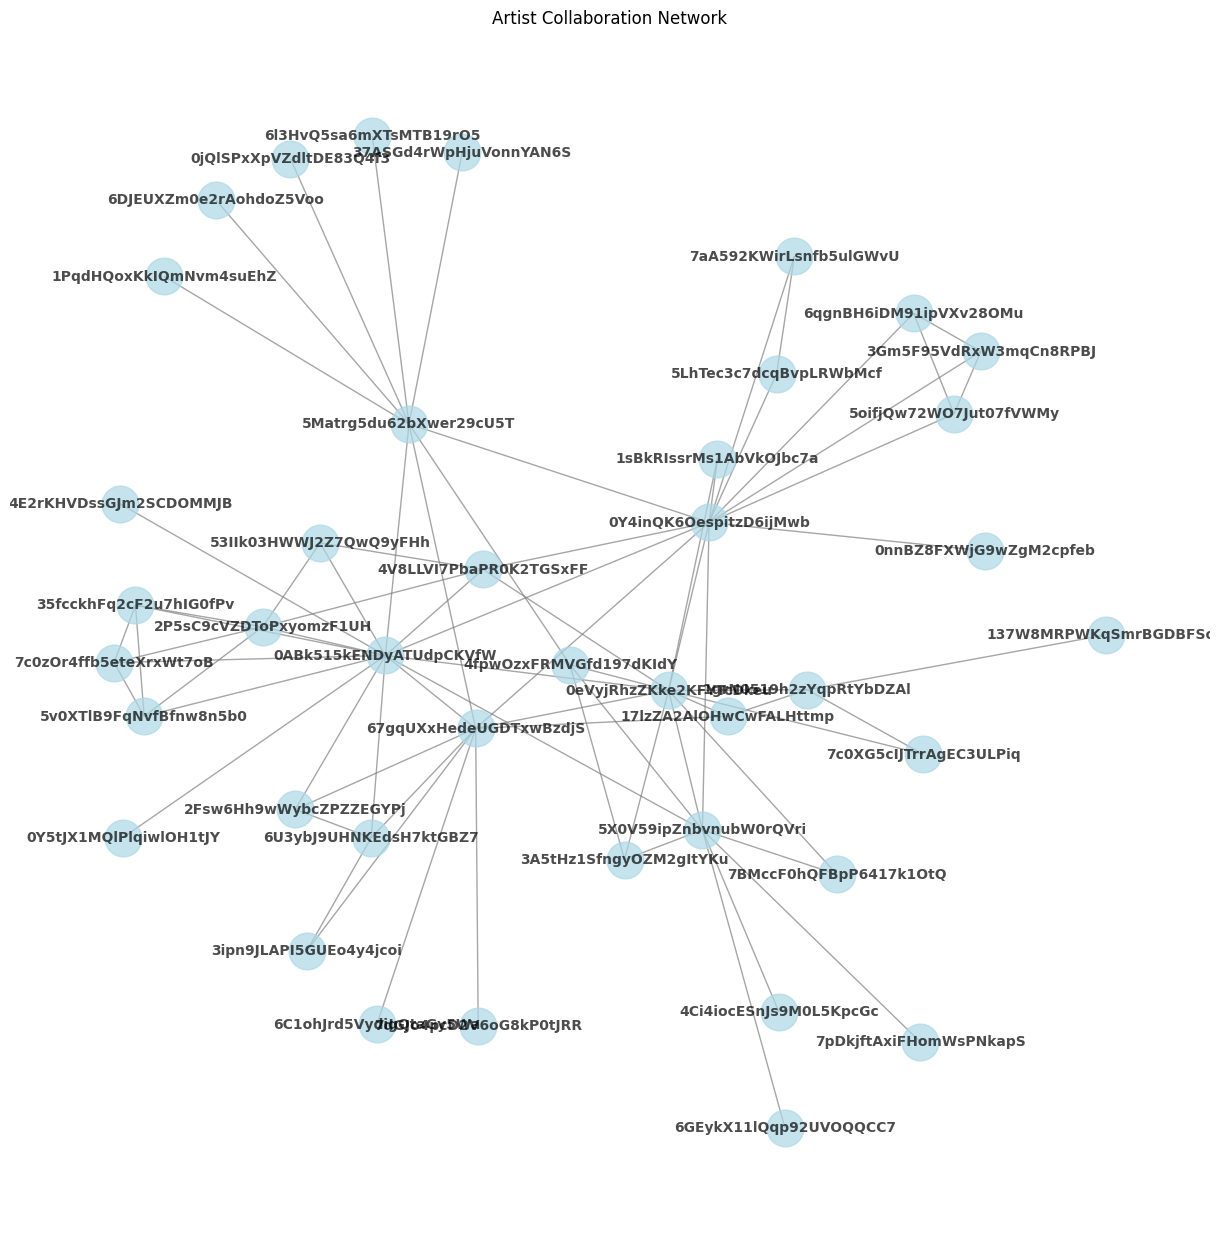

In [7]:
# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(g, seed=42)  # positions for all nodes
nx.draw(g, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray', alpha=0.7)
plt.title("Artist Collaboration Network")
plt.show()

In [8]:
def degree_of_seperation(artist1, artist2):
    """Calculate the degree of separation between two artists."""
    try:
        return nx.shortest_path_length(g, source=artist1, target=artist2)
    except nx.NetworkXNoPath:
        return float('inf')
all_artist_ids = list(g.nodes())

degree_of_seperation_dict = {}
for i in range(len(all_artist_ids)):
    degree_of_seperation_dict[all_artist_ids[i]] = {}
    for j in range(len(all_artist_ids)):
        if i != j:
            degree_of_seperation_dict[all_artist_ids[i]][all_artist_ids[j]] = degree_of_seperation(all_artist_ids[i], all_artist_ids[j])
degree_of_seperation_df = pd.DataFrame(degree_of_seperation_dict)
degree_of_seperation_df.fillna(0, inplace=True)
degree_of_seperation_df.index.name = "artist_id"
degree_of_seperation_df

,0ABk515kENDyATUdpCKVfW,4E2rKHVDssGJm2SCDOMMJB,0Y5tJX1MQlPlqiwlOH1tJY,2P5sC9cVZDToPxyomzF1UH,4V8LLVI7PbaPR0K2TGSxFF,53IIk03HWWJ2Z7QwQ9yFHh,5v0XTlB9FqNvfBfnw8n5b0,7c0zOr4ffb5eteXrxWt7oB,35fcckhFq2cF2u7hIG0fPv,0Y4inQK6OespitzD6ijMwb,...,37ASGd4rWpHjuVonnYAN6S,0jQlSPxXpVZdltDE83Q4f3,1grN0519h2zYqpRtYbDZAl,7c0XG5cIJTrrAgEC3ULPiq,137W8MRPWKqSmrBGDBFSop,3A5tHz1SfngyOZM2gItYKu,7BMccF0hQFBpP6417k1OtQ,7pDkjftAxiFHomWsPNkapS,6GEykX11lQqp92UVOQQCC7,4Ci4iocESnJs9M0L5KpcGc
artist_id,,,,,,,,,,,,,,,,,,,,,
4E2rKHVDssGJm2SCDOMMJB,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
0Y5tJX1MQlPlqiwlOH1tJY,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
2P5sC9cVZDToPxyomzF1UH,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
4V8LLVI7PbaPR0K2TGSxFF,1.0,2.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,...,3.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0
53IIk03HWWJ2Z7QwQ9yFHh,1.0,2.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
5v0XTlB9FqNvfBfnw8n5b0,1.0,2.0,2.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
7c0zOr4ffb5eteXrxWt7oB,1.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
35fcckhFq2cF2u7hIG0fPv,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
0Y4inQK6OespitzD6ijMwb,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0


In [9]:
artist_popularity = {}
for artists in all_artist_ids:
    artist_popularity[artists] = get_artist(artists)['popularity']
artist_popularity_df = pd.DataFrame(artist_popularity.items(), columns=['artist_id', 'popularity'])
artist_popularity_df['popularity'] = artist_popularity_df['popularity'].astype(int)
artist_popularity_df


,artist_id,popularity
0,0ABk515kENDyATUdpCKVfW,69
1,4E2rKHVDssGJm2SCDOMMJB,86
2,0Y5tJX1MQlPlqiwlOH1tJY,93
3,2P5sC9cVZDToPxyomzF1UH,73
4,4V8LLVI7PbaPR0K2TGSxFF,90
5,53IIk03HWWJ2Z7QwQ9yFHh,50
6,5v0XTlB9FqNvfBfnw8n5b0,53
7,7c0zOr4ffb5eteXrxWt7oB,55
8,35fcckhFq2cF2u7hIG0fPv,55
9,0Y4inQK6OespitzD6ijMwb,68


---

## Module 6 - Supervised Learning

In [21]:
collab_data = []

for artist_i in degree_of_seperation_df.index:
    for artist_j in degree_of_seperation_df.columns:
        if artist_i == artist_j:
            continue
        degree = degree_of_seperation_df.loc[artist_i, artist_j]
        has_collabed = 1 if g.has_edge(artist_i, artist_j) else 0
        collab_data.append({
            "artist_1": artist_i,
            "artist_2": artist_j,
            "degree_of_separation": degree,
            "collaborated": has_collabed
        })
collab_df = pd.DataFrame(collab_data)
collab_df

,artist_1,artist_2,degree_of_separation,collaborated
0,4E2rKHVDssGJm2SCDOMMJB,0ABk515kENDyATUdpCKVfW,1.0,1
1,4E2rKHVDssGJm2SCDOMMJB,0Y5tJX1MQlPlqiwlOH1tJY,2.0,0
2,4E2rKHVDssGJm2SCDOMMJB,2P5sC9cVZDToPxyomzF1UH,2.0,0
3,4E2rKHVDssGJm2SCDOMMJB,4V8LLVI7PbaPR0K2TGSxFF,2.0,0
4,4E2rKHVDssGJm2SCDOMMJB,53IIk03HWWJ2Z7QwQ9yFHh,2.0,0
...,...,...,...,...
1635,0ABk515kENDyATUdpCKVfW,3A5tHz1SfngyOZM2gItYKu,2.0,0
1636,0ABk515kENDyATUdpCKVfW,7BMccF0hQFBpP6417k1OtQ,2.0,0
1637,0ABk515kENDyATUdpCKVfW,7pDkjftAxiFHomWsPNkapS,2.0,0
1638,0ABk515kENDyATUdpCKVfW,6GEykX11lQqp92UVOQQCC7,2.0,0


In [22]:
collab_df = collab_df.merge(artist_popularity_df, left_on='artist_1', right_on='artist_id', how='left')
collab_df = collab_df.merge(track_collab_df, left_on=['artist_2', 'artist_1'], right_on=['source_artist', 'track_artist'], how='left')
collab_df.drop(columns=['artist_id'], inplace=True)
collab_df.rename(columns={'popularity': 'artist_1_popularity'}, inplace=True)

In [23]:
collab_df

,artist_1,artist_2,degree_of_separation,collaborated,artist_1_popularity,source_artist,track_artist,track_id,track_popularity
0,4E2rKHVDssGJm2SCDOMMJB,0ABk515kENDyATUdpCKVfW,1.0,1,86,0ABk515kENDyATUdpCKVfW,4E2rKHVDssGJm2SCDOMMJB,61b65LQ9rxhcMtDEusHPZL,68.0
1,4E2rKHVDssGJm2SCDOMMJB,0Y5tJX1MQlPlqiwlOH1tJY,2.0,0,86,NaN,NaN,NaN,NaN
2,4E2rKHVDssGJm2SCDOMMJB,2P5sC9cVZDToPxyomzF1UH,2.0,0,86,NaN,NaN,NaN,NaN
3,4E2rKHVDssGJm2SCDOMMJB,4V8LLVI7PbaPR0K2TGSxFF,2.0,0,86,NaN,NaN,NaN,NaN
4,4E2rKHVDssGJm2SCDOMMJB,53IIk03HWWJ2Z7QwQ9yFHh,2.0,0,86,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1665,0ABk515kENDyATUdpCKVfW,3A5tHz1SfngyOZM2gItYKu,2.0,0,69,NaN,NaN,NaN,NaN
1666,0ABk515kENDyATUdpCKVfW,7BMccF0hQFBpP6417k1OtQ,2.0,0,69,NaN,NaN,NaN,NaN
1667,0ABk515kENDyATUdpCKVfW,7pDkjftAxiFHomWsPNkapS,2.0,0,69,NaN,NaN,NaN,NaN
1668,0ABk515kENDyATUdpCKVfW,6GEykX11lQqp92UVOQQCC7,2.0,0,69,NaN,NaN,NaN,NaN


In [24]:
collab_df.drop(columns=['source_artist', 'track_artist', 'track_id'], inplace=True)
collab_df.rename(columns={'track_popularity': 'collab_popularity'}, inplace=True)

In [25]:
collab_df

,artist_1,artist_2,degree_of_separation,collaborated,artist_1_popularity,collab_popularity
0,4E2rKHVDssGJm2SCDOMMJB,0ABk515kENDyATUdpCKVfW,1.0,1,86,68.0
1,4E2rKHVDssGJm2SCDOMMJB,0Y5tJX1MQlPlqiwlOH1tJY,2.0,0,86,NaN
2,4E2rKHVDssGJm2SCDOMMJB,2P5sC9cVZDToPxyomzF1UH,2.0,0,86,NaN
3,4E2rKHVDssGJm2SCDOMMJB,4V8LLVI7PbaPR0K2TGSxFF,2.0,0,86,NaN
4,4E2rKHVDssGJm2SCDOMMJB,53IIk03HWWJ2Z7QwQ9yFHh,2.0,0,86,NaN
...,...,...,...,...,...,...
1665,0ABk515kENDyATUdpCKVfW,3A5tHz1SfngyOZM2gItYKu,2.0,0,69,NaN
1666,0ABk515kENDyATUdpCKVfW,7BMccF0hQFBpP6417k1OtQ,2.0,0,69,NaN
1667,0ABk515kENDyATUdpCKVfW,7pDkjftAxiFHomWsPNkapS,2.0,0,69,NaN
1668,0ABk515kENDyATUdpCKVfW,6GEykX11lQqp92UVOQQCC7,2.0,0,69,NaN


In [26]:
X = collab_df[["degree_of_separation", "artist_1_popularity"]]
y = collab_df["collaborated"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression()
pred = model.fit(X_train, y_train)

In [27]:
def predict_collab_probability(artist_a_id, artist_b_id, graph, model, pop_dict):
    # Degrees of separation
    try:
        degree = nx.shortest_path_length(graph, source=artist_a_id, target=artist_b_id)
    except nx.NetworkXNoPath:
        degree = 1000  # Use a large value to signify no connection
    
    # Popularities
    pop_a = pop_dict.get(artist_a_id, np.nan)
    pop_b = pop_dict.get(artist_b_id, np.nan)

    # Return None if we lack popularity info
    if np.isnan(pop_a) or np.isnan(pop_b):
        return None

    # Predict
    X_input = pd.DataFrame([{
        "degree_of_separation": degree,
        "popularity": pop_a
    }])
    
    return model.predict_proba(X_input)[0, 1]  # Probability of class 1

In [ ]:
popularity_dict = artist_popularity_df.groupby("artist_id")["popularity"].mean().to_dict()

prob = predict_collab_probability("4E2rKHVDssGJm2SCDOMMJB", "0Y5tJX1MQlPlqiwlOH1tJY", g, model, popularity_dict)
print(f"Probability of collaboration: {prob:.2f}")

Probability of collaboration: 0.02
